# Task 2: Speaker Classification from audio files

In [1]:
import os
import json
import tqdm
import torch
import random
import torch
import fairseq
import torchaudio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from libs.helper import get_mfcc_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## Wav2vec Encoder

In [2]:
# ref: https://github.com/facebookresearch/fairseq/issues/3134
wav2vec2_checkpoint_path = './checkpoints/wav2vec_small.pt'
checkpoint = torch.load(wav2vec2_checkpoint_path, weights_only=False)
cfg = fairseq.dataclass.utils.convert_namespace_to_omegaconf(checkpoint['args'])
wav2vec2_encoder = fairseq.models.wav2vec.Wav2Vec2Model.build_model(cfg.model)
wav2vec2_encoder.load_state_dict(checkpoint['model'])
wav2vec2_encoder.eval()

/mnt/nvme-data1/mtseng/miniconda3/envs/gender_speaker/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
        (3): GELU(approximate='none')
      )
      (1-4): 4 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate='none')
      )
      (5-6): 2 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): GELU(approximate='none')
      )
    )
  )
  (post_extract_proj): Linear(in_features=512, out_features=768, bias=True)
  (dropout_input): Dropout(p=0.1, inplace=False)
  (dropout_features): Dropout(p=0.1, inplace=False)
  (quantizer): GumbelVectorQuantizer(
    (weight_proj): Linear(in_features=512, out_feat

In [3]:
waveform, sample_rate = torchaudio.load('./LibriSpeech/dev-clean/174/50561/174-50561-0000.flac')
features = wav2vec2_encoder(waveform, features_only=True, mask=False)['x']
print(features.shape)

torch.Size([1, 200, 768])


## Data Preparation

In this section, we prepare the data for training. We split each audio into chunks and use wav2vec as the encoder to obtain the features. 

In [4]:
data_dir = './LibriSpeech'
info_path = './data/info.csv'
info = pd.read_csv(info_path)

In [5]:
fs = 16000
chunk_size = 2 * fs

speaker_data_path = './data/speaker_data.pkl'
if not os.path.exists(speaker_data_path):
    df = []
    for i in tqdm.tqdm(range(len(info))):
        row_data = info.iloc[i]
        speaker_id = row_data['speaker_id']
        audio_path = row_data['audio_path']
        waveform, sample_rate = torchaudio.load(os.path.join(data_dir, audio_path))
        assert sample_rate == fs

        if waveform.shape[1] < chunk_size:
            continue

        waveform_chunks = waveform.unfold(1, chunk_size, chunk_size) # split into 2s chunks with no overlap
        waveform_chunks = waveform_chunks.view(-1, chunk_size) # flatten the chunks
        
        features = wav2vec2_encoder(waveform_chunks, features_only=True, mask=False)['x']
        for j in range(features.shape[0]):
            df.append({
                'name': row_data['name'],
                'speaker_id': speaker_id,
                'features': features[j].detach().numpy(), # (T, C)
                'audio_path': audio_path,
                'chunk_idx': j
            })
    df = pd.DataFrame(df)
    df.to_pickle(speaker_data_path)
else:
    df = pd.read_pickle(speaker_data_path)
    print("Loaded speaker data")

Loaded speaker data


In [6]:
features = np.stack(df['features'].values)
avg_features = np.mean(features, axis=1)

Similar to Task 1, we first apply t-SNE to the extracted features to analyze their distribution. Since each audio file is processed into 2-second chunks, the resulting feature size is (T, D) = (99, 768), where T = 99 represents the temporal dimension and D = 768 is the feature embedding size.

To simplify the analysis, we compute the mean feature representation by averaging across the temporal dimension (T), reducing the feature shape to (1, 768) per audio chunk.

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
features_embedded = tsne.fit_transform(avg_features)

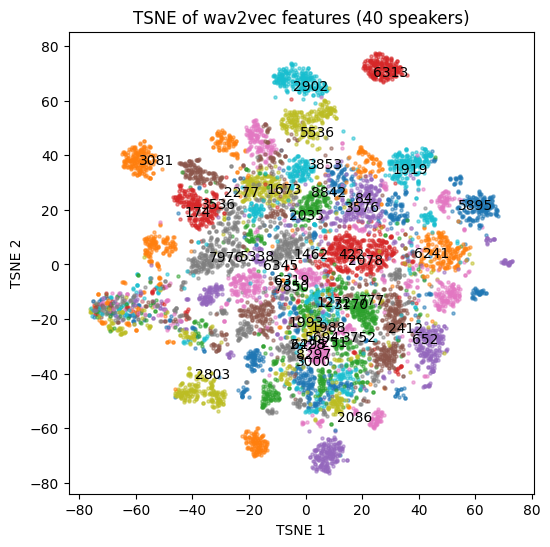

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i, subj in enumerate(df['speaker_id'].unique()):
    idx = df['speaker_id'] == subj
    centroid = np.mean(features_embedded[idx], axis=0)
    ax.text(centroid[0], centroid[1], subj)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], alpha=0.5, s=5)
plt.title("TSNE of wav2vec features (40 speakers)")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

Based on the t-SNE visualization, we observe that average features extracted from Wav2Vec2 for the same speaker tend to form distinct clusters. However, for some speakers, the data points are more dispersed, indicating that a two-dimensional representation may not be sufficient for clear separation.

Therefore, in the following section, we will design machine learning models to improve speaker classification by leveraging higher-dimensional feature spaces.

## Speaker Classification

### 1. Train Test Split

In this section, we first split the data into training and testing sets. Unlike Task 1, which uses a cross-subject split, we apply a cross-audio split, ensuring that the same audio file does not appear in both the training and testing sets. This approach prevents data leakage, ensuring that the model generalizes to unseen audio rather than memorizing specific recordings.

We also use stratified K-fold cross-validation to split the data, ensuring that the proportion of each speaker remains consistent between the training and testing sets.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

audio_df = df.drop_duplicates(subset='audio_path', keep='first')
X = audio_df['audio_path']
y = audio_df['speaker_id']

train_audios = []
test_audios = []

for train_index, test_index in skf.split(X, y):
    train_audios.append(X.iloc[train_index].values)
    test_audios.append(X.iloc[test_index].values)


In [10]:
metadata_path = "./data/task2_metadata.json"

if not os.path.exists(metadata_path):
    metadata = {}
    for i in range(len(train_audios)):
        metadata[f"fold_{i}"] = {
            "train": train_audios[i].tolist(),
            "test": test_audios[i].tolist()
        }

    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)

else:
    print("metadata already exists")
    with open (metadata_path, "r") as f:
        metadata = json.load(f)

metadata already exists


In [11]:
train_df = df[df['audio_path'].isin(train_audios[0])]
test_df = df[df['audio_path'].isin(test_audios[0])]

print("Number of train audio: {} | # speakers: {}".format(len(train_df['audio_path'].unique()), len(train_df['speaker_id'].unique())))
print("Number of test audio: {} | # speakers: {}".format(len(test_df['audio_path'].unique()), len(test_df['speaker_id'].unique())))

Number of train audio: 2132 | # speakers: 40
Number of test audio: 534 | # speakers: 40


### 2. Classifier

Since we are working with sequential data, we use an LSTM-based model to capture temporal dependencies in speaker embeddings. Unlike static feature averaging, LSTMs can preserve sequential patterns in speech, helping to better differentiate speakers based on their unique vocal characteristics.

In [12]:
class SpeakerData(Dataset):
    def __init__(self, data, subject_map):
        super().__init__()
        self.data = data
        self.subject_map = subject_map
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = row['features']
        speaker_id = self.subject_map[row['speaker_id']]
        return features, speaker_id
    
    def __len__(self):
        return len(self.data)
    

class SpeakerDataLoader():
    def __init__(self, data, metadata):
        self.subjects = sorted(data['speaker_id'].unique())
        self.subject_map = {subj: i for i, subj in enumerate(self.subjects)}
        self.subject_map_inv = {i: subj for i, subj in enumerate(self.subjects)}

        self.train_data = data[data['audio_path'].isin(metadata['train'])]
        self.test_data = data[data['audio_path'].isin(metadata['test'])]

        self.train_dataset = SpeakerData(self.train_data, self.subject_map)
        self.test_dataset = SpeakerData(self.test_data, self.subject_map)
    
    def get_loader(self, data_type, batch_size=32, shuffle=True):
        if data_type == 'train':
            dataset = self.train_dataset
        else:
            dataset = self.test_dataset

        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [13]:
class SpeakerModel(nn.Module):
    def __init__(self, max_token=99, n_embd=768, n_classes=40):
        super(SpeakerModel, self).__init__()
        self.max_token = max_token
        self.n_embd = n_embd
        self.bi_lstm = nn.LSTM(input_size=n_embd, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

        self._init_weights()
        
    def forward(self, x):
        x, _ = self.bi_lstm(x)
        feat = x = x[:, -1, :]
        x = self.classifier(feat)
        return x, feat
    
    def predict(self, x):
        x, _ = self.bi_lstm(x)
        feat = x = x[:, -1, :]
        x = self.classifier(feat)
        x = F.softmax(x, dim=1)
        return x, feat

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'bias' in name:
                        nn.init.zeros_(param)
                    elif 'weight' in name:
                        nn.init.orthogonal_(param)

In [15]:
speaker_result = [] 
for fold_id in metadata.keys():
    print(f"Training fold {fold_id}")   
    scaler = StandardScaler()

    speaker_model = SpeakerModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(speaker_model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    speaker_model.to(device)

    loader = SpeakerDataLoader(df, metadata[fold_id])
    train_loader = loader.get_loader('train', batch_size=32, shuffle=True)
    test_loader = loader.get_loader('test', batch_size=32, shuffle=False)

    # Train the model
    checkpoint_path = f'./checkpoints/speaker_model/{fold_id}.pth'
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    num_epochs = 20
    best_loss = np.inf
    best_epoch = 0
    early_stopping_patience = 10
    for epoch in range(num_epochs):
        speaker_model.train()
        train_loss = []
        for wav2vec_features, labels in train_loader:
            wav2vec_features, labels = wav2vec_features.float().to(device), labels.to(device)
            optimizer.zero_grad()
            preds, _ = speaker_model(wav2vec_features)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        test_loss = []
        speaker_model.eval()
        with torch.no_grad():
            for wav2vec_features, labels in test_loader:
                wav2vec_features, labels = wav2vec_features.float().to(device), labels.to(device)
                preds, _ = speaker_model(wav2vec_features)
                loss = criterion(preds, labels)
                test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        scheduler.step(test_loss)
        
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': speaker_model.state_dict(),
                'loss': test_loss,
                'scaler': scaler,
            }, checkpoint_path)

        print(f"Epoch {epoch+1}/{num_epochs} | train loss: {train_loss:.4f} | test loss: {test_loss:.4f} | lr: {optimizer.param_groups[0]['lr']}")
        if epoch - best_epoch > early_stopping_patience:
            print("Early stopping")
            break

    print("Finished training, save model at epoch: {}".format(best_epoch))
    print("")
    
    # Evaluate the model
    speaker_model.load_state_dict(torch.load(checkpoint_path, weights_only=False)['model_state_dict'])
    speaker_model.eval()
    with torch.no_grad():
        for data_type, loader in zip(['train', 'test'], [train_loader, test_loader]):
            for wav2vec_features, labels in loader:
                wav2vec_features, labels = wav2vec_features.float().to(device), labels.to(device)

                preds, _ = speaker_model.predict(wav2vec_features)
                preds = torch.argmax(preds, dim=1).cpu().numpy()
                labels = labels.cpu().numpy()
                
                speaker_result.append({
                    'data_type': data_type,
                    'fold_id': fold_id,
                    'preds': preds,
                    'labels': labels
                })

speaker_result = pd.DataFrame(speaker_result)

Training fold fold_0
Epoch 1/20 | train loss: 3.0401 | test loss: 2.1785 | lr: 0.001
Epoch 2/20 | train loss: 1.5375 | test loss: 1.0130 | lr: 0.001
Epoch 3/20 | train loss: 0.8373 | test loss: 1.1080 | lr: 0.001
Epoch 4/20 | train loss: 0.4709 | test loss: 0.6860 | lr: 0.001
Epoch 5/20 | train loss: 0.2927 | test loss: 0.3586 | lr: 0.001
Epoch 6/20 | train loss: 0.2486 | test loss: 0.3746 | lr: 0.001
Epoch 7/20 | train loss: 0.1968 | test loss: 0.2337 | lr: 0.001
Epoch 8/20 | train loss: 0.1307 | test loss: 0.1823 | lr: 0.001
Epoch 9/20 | train loss: 0.1057 | test loss: 0.2125 | lr: 0.001
Epoch 10/20 | train loss: 0.0794 | test loss: 0.1591 | lr: 0.001
Epoch 11/20 | train loss: 0.0889 | test loss: 0.1452 | lr: 0.001
Epoch 12/20 | train loss: 0.1032 | test loss: 0.1957 | lr: 0.001
Epoch 13/20 | train loss: 0.0781 | test loss: 0.1199 | lr: 0.001
Epoch 14/20 | train loss: 0.0814 | test loss: 0.0919 | lr: 0.001
Epoch 15/20 | train loss: 0.0862 | test loss: 0.0901 | lr: 0.001
Epoch 16/20 |

### 3. Evaluation

#### 3.1 Confusion Matrix

In [16]:
subjects = sorted(df['speaker_id'].unique())
subjects_map = {subj: i for i, subj in enumerate(subjects)}
subjects_map_inv = {i: subj for i, subj in enumerate(subjects)}

In [17]:
def evaluate(df):
    def calculate_confusion_matrix(preds, labels):
        confusion_matrix = np.zeros((40, 40))
        for i in range(len(preds)):
            confusion_matrix[labels[i], preds[i]] += 1
        return confusion_matrix
    
    train_result = df[df['data_type'] == 'train']
    test_result = df[df['data_type'] == 'test']

    train_confusion_matrices = []
    test_confusion_matrices = []

    for fold_id in sorted(train_result['fold_id'].unique()):
        train_fold = train_result[train_result['fold_id'] == fold_id]
        test_fold = test_result[test_result['fold_id'] == fold_id]

        train_confusion_matrix = calculate_confusion_matrix(np.concatenate(train_fold['preds'].values), np.concatenate(train_fold['labels'].values))
        test_confusion_matrix = calculate_confusion_matrix(np.concatenate(test_fold['preds'].values), np.concatenate(test_fold['labels'].values))

        train_confusion_matrices.append(train_confusion_matrix)
        test_confusion_matrices.append(test_confusion_matrix)

    train_confusion_matrices = np.stack(train_confusion_matrices)
    test_confusion_matrices = np.stack(test_confusion_matrices)
    
    return train_confusion_matrices, test_confusion_matrices

def plot_confusion_matrix(train_cms, test_cms, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 7))
    # Loop over train and test data
    
    for i, (data_type, data) in enumerate(zip(['Train', 'Test'], [train_cms, test_cms])):
        # Plot heatmap
        cm = [cm / cm.sum() for cm in data]
        cm = np.mean(cm, axis=0)
        
        sns.heatmap(cm, annot=False, fmt=".2f", cmap='Blues', ax=axes[i], cbar=False)

        labels = [subjects_map_inv[i] for i in range(40)]

        axes[i].set_title(f"{data_type} Set: Accuracy {cm.trace() * 100:.2f}%")
        axes[i].set_xlabel('Predicted Label', fontsize=12)
        axes[i].set_ylabel('Ground Truth Label', fontsize=12)
        axes[i].set_xticks(np.arange(len(labels)) + 0.5)
        axes[i].set_yticks(np.arange(len(labels)) + 0.5)
        axes[i].set_xticklabels(labels, rotation=90)
        axes[i].set_yticklabels(labels, rotation=0)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

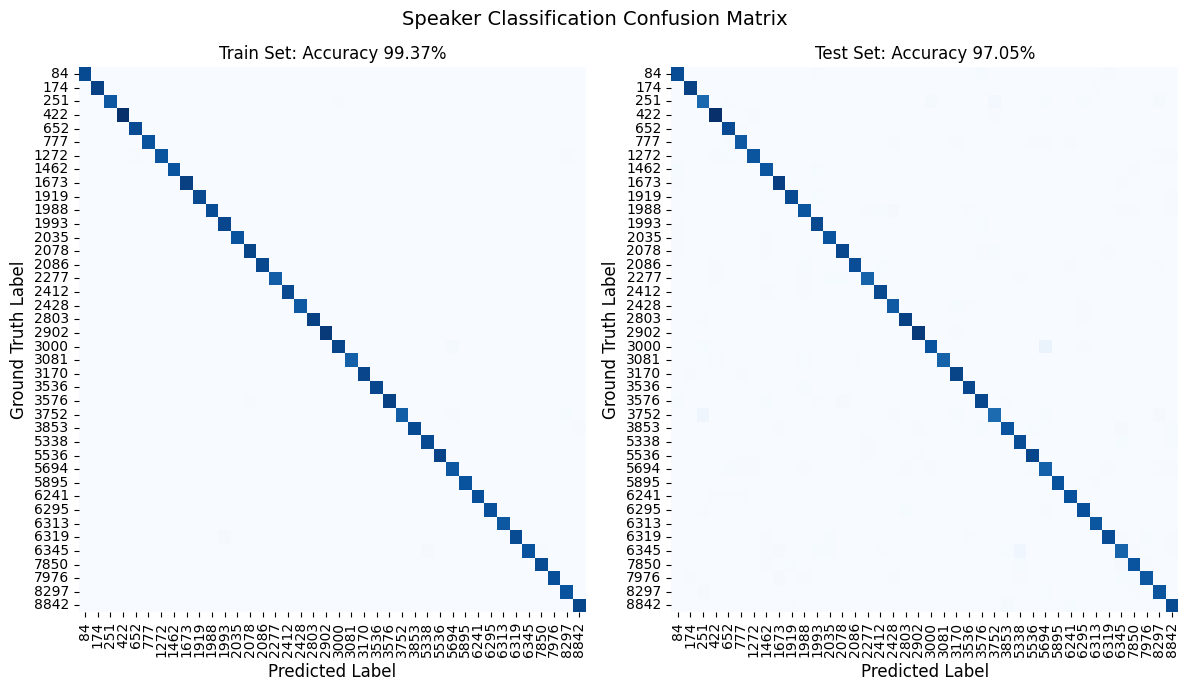

In [18]:
train_cms, test_cms = evaluate(speaker_result)
plot_confusion_matrix(train_cms, test_cms, "Speaker Classification Confusion Matrix")

#### 3.2 Speaker Embeddings

In this section, we analyze speaker embeddings using t-SNE, using Fold 0 as an example. Compared to the average Wav2Vec2 features, the LSTM-based speaker embeddings exhibit greater cluster separability, indicating that the LSTM model captures more discriminative speaker-specific characteristics.

In [19]:
folder_id = 'fold_0'
speaker_model = SpeakerModel()
checkpoint_path = f'./checkpoints/speaker_model/{folder_id}.pth'
speaker_model.load_state_dict(torch.load(checkpoint_path, weights_only=False)['model_state_dict'])
speaker_model.to(device)
speaker_model.eval()

loader = SpeakerDataLoader(df, metadata[folder_id])
test_loader = loader.get_loader('test', batch_size=32, shuffle=False)

features = []
gt_labels = []
with torch.no_grad():
    for wav2vec_features, labels in test_loader:
        wav2vec_features, labels = wav2vec_features.float().to(device), labels.to(device)

        _, feats = speaker_model.predict(wav2vec_features)
        features.append(feats.cpu().numpy())
        gt_labels.append(labels.cpu().numpy())
features = np.concatenate(features)
gt_labels = np.concatenate(gt_labels)

In [20]:
tsne = TSNE(n_components=2, random_state=0)
features_embedded = tsne.fit_transform(features)

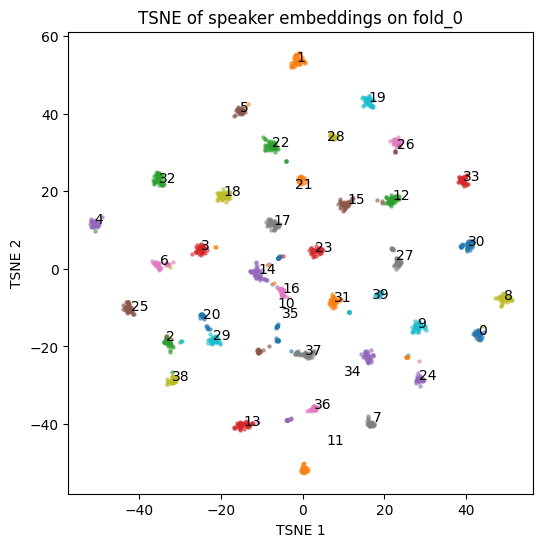

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i, subj in enumerate(list(set(gt_labels))):
    idx = gt_labels == subj
    centroid = np.mean(features_embedded[idx], axis=0)
    ax.text(centroid[0], centroid[1], subj)
    ax.scatter(features_embedded[idx, 0], features_embedded[idx, 1], alpha=0.5, s=5)

plt.title("TSNE of speaker embeddings on {}".format(folder_id))
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()